### Read libraries.



In [107]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
#import phase_portraits as pp
#from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets#
import ipywidgets as widgets
import pandas as pd
from IPython.display import Image
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import odeint
import pymc as pm
import arviz as az
from scipy.interpolate import interp1d

%matplotlib inline

## SIRS modellen

We are going to look at the following SIRS modell with vaccination:
$$
\begin{array}{rl}
\displaystyle\frac{dS}{dt}  & = -  \beta I S + \delta R \\[5mm]
\displaystyle\frac{dI}{dt}  & =  \beta I S - \gamma I  \\[5mm]
\displaystyle\frac{dR}{dt}  & = \gamma I -\delta R  \nonumber
\end{array}
$$

This is an example of a compartment model, simulating how people are moving from one compartment to the other. When susceptible, $S$, meet infected $I$ they have a certain probability of being infected. After a while the infected recover, entering the $R$ compartment. In this model the recovered are again transferred back to the $S$ compartment, they are only immune for a certain amount of time. In the model we can also have an arrow bringing individuals from $S$ to $R$ directly, assuming that the vaccination is only efficient for the same time as for the individual recovered after an infection. The vaccination effort, denoted $V$ in the figure. We're later going to assume that $V$ is either a constant, i.e. a continuous vaccination program, or proportional to the infection level, i.e. reaction to an outbreak.

where $S$, $I$ and $R$ are, respectively, the fraction of the population that are susceptible, infected, and recovered. This is an example of a compartment model, simulating how people are moving from one compartment to the other. When susceptible, $S$, meet infected *I* they have a certain probability of being infected. *V* represent vaccination, i.e. moving individuals directly from *S* to *R*. 








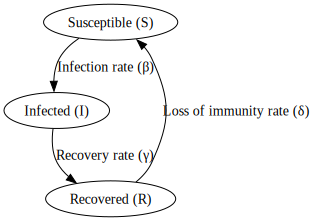

In [77]:
from graphviz import Digraph
from IPython.display import display

dot = Digraph()

# Nodes
dot.node('S', 'Susceptible (S)', pos='0,1!')
dot.node('I', 'Infected (I)', pos='1,0!')
dot.node('R', 'Recovered (R)', pos='0,-1!')

# Edges
dot.edge('S', 'I', label='Infection rate (β)')
dot.edge('I', 'R', label='Recovery rate (γ)')
dot.edge('R', 'S', label='Loss of immunity rate (δ)')

# Set graph attributes for circular layout
dot.attr(overlap='false')
dot.attr(splines='true')

# Display the graph inline
display(dot)


We will for the moment work with an non-dimensional version of the model. Introducing a charactiristic time scale to 1/$\gamma$, i.e. the average recovery time. So $t=\tau \gamma$ our new model equations become
$$
\begin{array}{rl}
\displaystyle\frac{dS}{d\tau}  & = -  R_m I S + \Delta R \\[5mm]
\displaystyle\frac{dI}{d\tau}  & =  R_m I S -  I  \\[5mm]
\displaystyle\frac{dR}{d\tau}  & =  I -\Delta R  \nonumber
\end{array}
$$
In the figure that follows, we have that $S+I+R=1$, and the _time_ has unit of how long infected people stay sick. 

In [78]:
# The SIRS model differential equations.

days = range(0, 40)

def deriv(state, t, R0, Delta):
    S, I, R = state
    # Change in S population over time
    dSdt = - R0 * S * I + Delta*R
    # Change in I population over time
    dIdt = R0 * S * I -  I
    # Change in R population over time
    dRdt =   I - Delta*R
    return dSdt, dIdt, dRdt


#mylayout =Layout(width='10cm')

def g(time,Delta,R0):
    init=[0.99,0.01,0]
    days=np.linspace(0, time,num=10*time)
    ret = odeint(deriv, init,
             days,
             args=(R0 ,Delta))

    S, I, R = ret.T

    df = pd.DataFrame({
    'susceptible': S,
    'infectious': I,
    'recovered': R,
    'time': days})

    # Create figures
    fig=plt.figure()
    fig.tight_layout(pad=6.0)
    ax_upper = plt.subplot2grid((2, 2), (0, 0), colspan=2)

    ax_lower_left = plt.subplot2grid((2, 2), (1, 0))
    ax_lower_right = plt.subplot2grid((2, 2), (1, 1))
    plt.subplots_adjust(hspace=0.5)
    df.plot(x='time',
            y=['infectious', 'susceptible', 'recovered'],
            color=['#bb6424', '#aac6ca', '#cc8ac0'],
            ax=ax_upper )
    
    df.plot(x='susceptible',
            y=['infectious'],
            color=['#bb6424'],
            ax=ax_lower_left )
    df.plot(x='susceptible',
            y=[ 'recovered'],
            color=['#cc8ac0'],
            ax=ax_lower_right )
    ax_lower_right.set_ybound(0,1.)
    ax_lower_left.set_ybound(0,1.)
    
    plt.show()

    print('max number of infected =',np.max(I));


interact(g, 
            time=widgets.Dropdown(
                options=[10,40, 100, 160],
                value=10,
                description='end time:',
                disabled=False,),
            Delta=widgets.Dropdown(
                options=[0., 0.01, 0.02, 0.05, 0.1,0.5,1.],
                value=0.,
                description='Delta:',
                disabled=False,),
             R0=widgets.FloatSlider(min=0.5, max=10., step=0.1, value=3.8, description='R0:',
                                  continuous_update=False,readout=True, readout_format='.1f'));



interactive(children=(Dropdown(description='end time:', options=(10, 40, 100, 160), value=10), Dropdown(descri…

Remember, as long as $\Delta$ (Delta) is equal to zero, we have a regular SIR model. Once recovered you will stay immune for all eternity. Once we give a positive value to $\Delta$, we will be moved back into the $S$ compartment after a while, and can get sick again. 

Try the following: 
- As usuall, higher $R_0$ means earlier peak and the maximum number of infected at any time is higher. 
- Set $Delta$ to 0.01, the recovered individuals will be transfered back to S and we get a second peak. Remember to set the end time to a larger value to see it. 



## Sannsynlighetsfordelinger

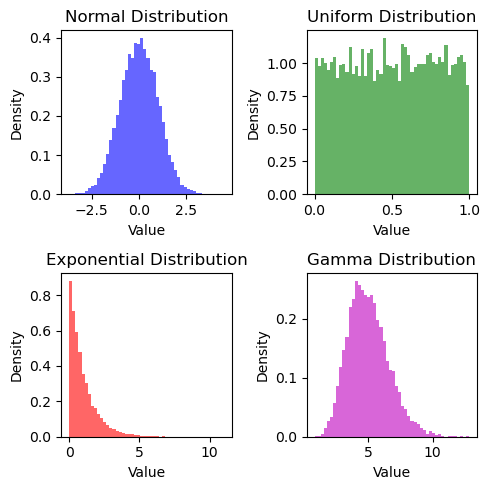

In [101]:

# Number of samples
num_samples = 10000

# Generate samples from different distributions
normal_samples = np.random.normal(loc=0, scale=1, size=num_samples)
uniform_samples = np.random.uniform(low=0, high=1, size=num_samples)
exponential_samples = np.random.exponential(scale=1, size=num_samples)
gamma_samples = np.random.gamma(shape=10, scale=0.5, size=num_samples)

# Plot the distributions
plt.figure(figsize=(5, 5))

# Normal Distribution
plt.subplot(2, 2, 1)
plt.hist(normal_samples, bins=50, density=True, alpha=0.6, color='b')
plt.title('Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

# Uniform Distribution
plt.subplot(2, 2, 2)
plt.hist(uniform_samples, bins=50, density=True, alpha=0.6, color='g')
plt.title('Uniform Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

# Exponential Distribution
plt.subplot(2, 2, 3)
plt.hist(exponential_samples, bins=50, density=True, alpha=0.6, color='r')
plt.title('Exponential Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

# Gamma Distribution
plt.subplot(2, 2, 4)
plt.hist(gamma_samples, bins=50, density=True, alpha=0.6, color='m')
plt.title('Gamma Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


## Usikkerhet i parameter
Anta a parametrene i SIR modellen vår følger normalfordelinger: 
$$
\beta \sim N(\overline{\beta},\sigma_\beta) \\
\gamma \sim N(\overline{\gamma},\sigma_\gamma)
$$
I SIR modeller er $R_0$ tallet

$$
 R_0 = \frac{\beta}{\gamma}.
$$
Vi kan finne en fordeling på $R_0$ ved å bruke MCMC:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, gamma]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


R test for distribusjon:
('lognorm', (0.2424362487838171, -0.80488333180763, 2.8086652052159575), {'norm': 0.05912247645854196, 'expon': 0.371618843275338, 'lognorm': 0.01436640561355379, 'gamma': 0.019054347744349887, 'weibull_min': 0.06153087605478415})



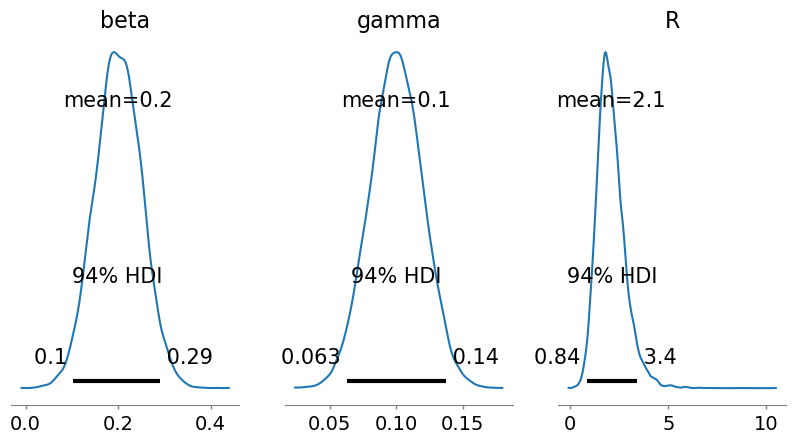

In [81]:

def test_distributions(data):
# Test which distribution that is closest to the data. 
    distributions = ['norm', 'expon', 'lognorm', 'gamma', 'weibull_min']
    results = {}
    params_dict = {}

    for distribution in distributions:
        dist = getattr(stats, distribution)
        params = dist.fit(data)
        ks_stat, p_value = stats.kstest(data, distribution, args=params)
        results[distribution] = ks_stat
        params_dict[distribution] = params

    closest_distribution = min(results, key=results.get)
    return closest_distribution, params_dict[closest_distribution], results




def plot_distribution(data, distribution, params):
    # Generate the PDF values
    x = np.linspace(min(data), max(data), 100)
    dist = getattr(stats, distribution)
    pdf_values = dist.pdf(x, *params)

    # Plot the normalized histogram and the PDF
    plt.hist(data, bins=40, density=True, alpha=0.6, color='g', label='Data')
    plt.plot(x, pdf_values, label=f'{distribution} PDF')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Normalized Histogram and {distribution} PDF')
    plt.legend()
    plt.show()

# Parameters for the normal distributions
beta_mean = 0.2
beta_std = 0.05
gamma_mean = 0.1
gamma_std = 0.02

# Define the PyMC model
with pm.Model() as model:
    # Priors for beta and gamma
    beta = pm.Normal('beta', mu=beta_mean, sigma=beta_std)
    gamma = pm.Normal('gamma', mu=gamma_mean, sigma=gamma_std)
    
    # Deterministic transformation for R
    R = pm.Deterministic('R', beta / gamma)
    
    # Sample from the posterior
    trace = pm.sample(5000, tune=1000, progressbar=False, return_inferencedata=True)

print('R test for distribusjon:')
print(test_distributions(trace.posterior.R.values.flatten()))
print()
fig,axs = plt.subplots(1,3)
fig.set_figwidth(10)
az.plot_posterior(trace, var_names=['beta'],ax=axs[0])
az.plot_posterior(trace, var_names=['gamma'],ax=axs[1])
# Plot the posterior distribution of R
az.plot_posterior(trace, var_names=['R'],ax=axs[2])
plt.show()





In [91]:

closest_distribution, params_dict, results=test_distributions(trace.posterior.R.values.flatten())
print('R test for distribusjon:')
print(closest_distribution, params_dict)
print(results)
print()

R test for distribusjon:
lognorm (0.2424362487838171, -0.80488333180763, 2.8086652052159575)
{'norm': 0.05912247645854196, 'expon': 0.371618843275338, 'lognorm': 0.01436640561355379, 'gamma': 0.019054347744349887, 'weibull_min': 0.06153087605478415}



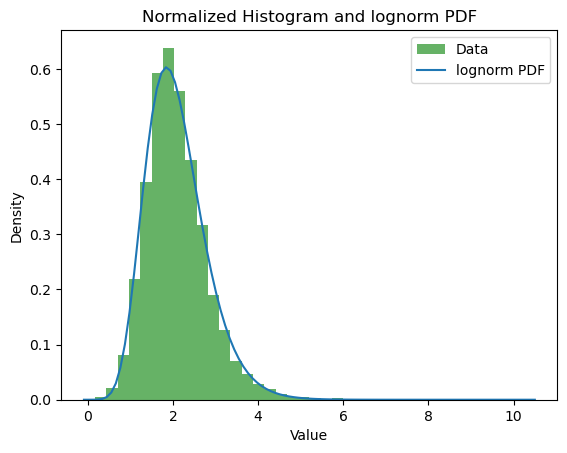

In [164]:
plot_distribution(trace.posterior.R.values.flatten(), closest_distribution, params_dict)

## SIR model med usikkerhet

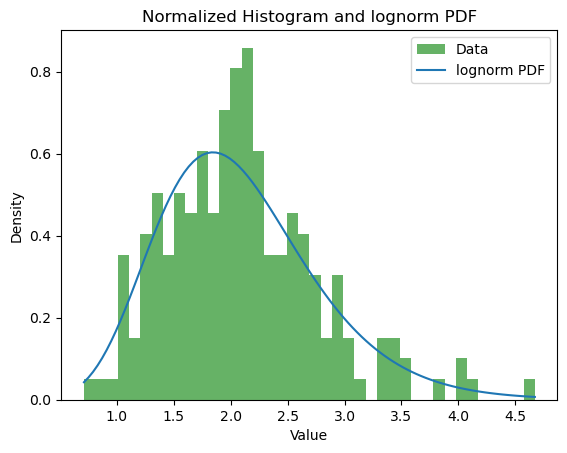

In [165]:
def draw_samples(distribution_name, params, size=100):
    # Draw samples from the specified distribution with given parameters.
    dist = getattr(stats, distribution_name)
    samples = dist.rvs(*params[:-2], loc=params[-2], scale=params[-1], size=size)
    return samples
dist = draw_samples(closest_distribution,params_dict,size=200)
plot_distribution(dist, closest_distribution, params_dict)


In [278]:
# The SIRS model differential equations.



def deriv(state, t, R0, Delta):
    S, I, R = state
    # Change in S population over time
    dSdt = - R0 * S * I + Delta*R
    # Change in I population over time
    dIdt = R0 * S * I -  I
    # Change in R population over time
    dRdt =   I - Delta*R
    return dSdt, dIdt, dRdt


#mylayout =Layout(width='10cm')

def g(time,Delta,R0_mn,R0_sd):
    num_simulations=100
    init=[0.99,0.01,0]
    days=np.linspace(0, time,num=10*time)
    results = []
    for _ in range(num_simulations):
    # Draw R_0 from Gaussian distributions
        R0 = np.random.normal(R0_mn, R0_sd)
        ret = odeint(deriv, init,
             days,
             args=(R0 ,Delta))
        
        results.append(ret)
    # Solve ODE

    
    results = np.array(results)




    # Create figures
    fig=plt.figure()
    fig.tight_layout(pad=6.0)
    ax_upper = plt.subplot2grid((2, 2), (0, 0), colspan=2)

    ax_lower_left = plt.subplot2grid((2, 2), (1, 0))
    ax_lower_right = plt.subplot2grid((2, 2), (1, 1))
    plt.subplots_adjust(hspace=0.5)
    for result in results:
        
        S, I, R = result.T
        
        ax_upper.plot(days, S, color='#aac6ca', alpha=0.1)
        ax_upper.plot(days, I, color='#bb6424', alpha=0.1)
        ax_upper.plot(days, R, color='#cc8ac0', alpha=0.1)

        ax_lower_left.plot(S, I, color='#bb6424', alpha=0.1)
        ax_lower_right.plot(S, R, color='#cc8ac0', alpha=0.1)

    
    #ax_lower_right.set_ybound(0,1.)
    #ax_lower_left.set_ybound(0,1.)
    
    plt.show()

    


interact(g, 
            time=widgets.Dropdown(
                options=[10,40, 100, 160],
                value=10,
                description='time:',
                disabled=False,),
            Delta=widgets.Dropdown(
                options=[0., 0.01, 0.02, 0.05, 0.1,0.5,1.],
                value=0.,
                description='Delta:',
                disabled=False,),
            R0_mn=widgets.FloatSlider(min=0.5, max=10., step=0.1, value=3.8, description='R0 mean:',
                                  continuous_update=False,readout=True, readout_format='.1f'),
            R0_sd=widgets.FloatSlider(min=0., max=1., step=0.1, value=0.1, description='R0 std:',
                                  continuous_update=False,readout=True, readout_format='.1f'));



interactive(children=(Dropdown(description='time:', options=(10, 40, 100, 160), value=10), Dropdown(descriptio…

## Time varying R

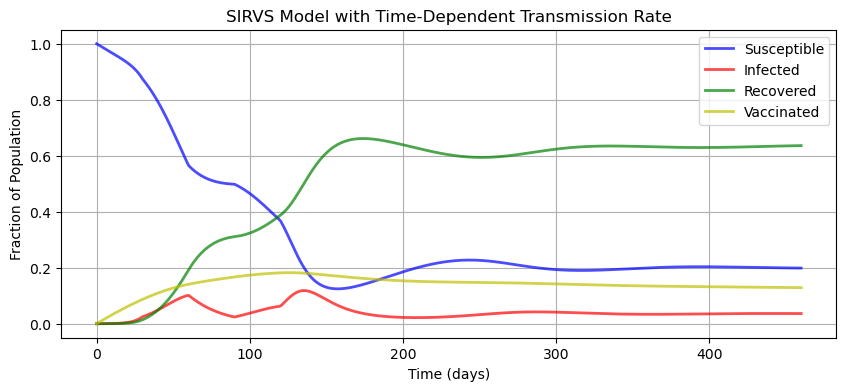

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
N = 10000  # Total population
I0, R0, V0 = 1, 0, 0  # Initial number of infected, recovered, and vaccinated individuals
S0 = N - I0 - R0 - V0  # Initial number of susceptible individuals
gamma = 1/10  # Recovery rate (1/days)
delta = 1/300  # Vaccination rate (1/days)
epsilon = 1/180  # Waning immunity rate (1/days)
days = 460  # Number of days to simulate

# Time-dependent transmission rate function
def beta(t):
    if t < 30:
        return 0.3
    elif t < 60:
        return 0.2
    elif t < 90:
        return 0.1
    elif t<120:
        return 0.3
    else:
        return 0.5

# SIRVS model differential equations
def deriv(y, t, N, beta, gamma, delta, epsilon):
    S, I, R, V = y
    dSdt = -beta(t) * S * I / N - delta * S + epsilon * (V+R)
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I - epsilon * R
    dVdt = delta * S - epsilon * V
    return dSdt, dIdt, dRdt, dVdt

# Initial conditions vector
y0 = S0, I0, R0, V0

# Integrate the SIRVS equations over the time grid, t.
t = np.linspace(0, days, days)
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, epsilon))
S, I, R, V = ret.T

# Plot the data on four separate curves for S(t), I(t), R(t), and V(t)
fig = plt.figure(figsize=(10, 4))
plt.plot(t, S/N, 'b', alpha=0.7, linewidth=2, label='Susceptible')
plt.plot(t, I/N, 'r', alpha=0.7, linewidth=2, label='Infected')
plt.plot(t, R/N, 'g', alpha=0.7, linewidth=2, label='Recovered')
plt.plot(t, V/N, 'y', alpha=0.7, linewidth=2, label='Vaccinated')
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Population')
plt.title('SIRVS Model with Time-Dependent Transmission Rate')
plt.legend()
plt.grid(True)
plt.show()


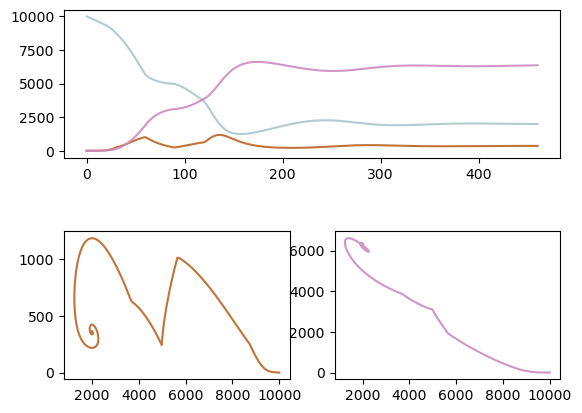

In [295]:
# Create figures
fig=plt.figure()
fig.tight_layout(pad=6.0)
ax_upper = plt.subplot2grid((2, 2), (0, 0), colspan=2)

ax_lower_left = plt.subplot2grid((2, 2), (1, 0))
ax_lower_right = plt.subplot2grid((2, 2), (1, 1))
plt.subplots_adjust(hspace=0.5)
        

ax_upper.plot(t, S, color='#aac6ca', alpha=0.9)
ax_upper.plot(t, I, color='#bb6424', alpha=0.9)
ax_upper.plot(t, R, color='#cc8ac0', alpha=0.9)
#ax_upper.plot(t, f_R(days), color='k', alpha=0.9)

ax_lower_left.plot(S, I, color='#bb6424', alpha=0.9)
ax_lower_right.plot(S, R, color='#cc8ac0', alpha=0.9)

#ax_lower_right.set_ybound(0,1.)
#ax_lower_left.set_ybound(0,1.)
    
plt.show()

## Bayes theorem
Bayes’ theorem can be used to update the probability of a hypothesis (e.g., having a disease) based on new evidence (e.g., a positive test result). The formula is:
$$
 P(Disease∣Positive Test)=\frac{P(Positive Test∣Disease)⋅P(Disease)}{P(Positive Test)}​
$$
Where:

( $P(\text{Disease} | \text{Positive Test})$ ) is the probability of having the disease given a positive test result.

( $P(\text{Positive Test} | \text{Disease}) $) is the probability of testing positive if you have the disease (sensitivity).

( $P(\text{Disease}) $) is the prior probability of having the disease (prevalence).

( $P(\text{Positive Test}) $) is the total probability of testing positive.

In [231]:
# Define the probabilities
P_Disease = 0.01  # Prevalence of the disease
P_Positive_given_Disease = 0.99  # Sensitivity (True Positive Rate)
P_Negative_given_No_Disease = 0.95  # Specificity (True Negative Rate)

# Calculate the probability of a positive test result
P_No_Disease = 1 - P_Disease
P_Positive_given_No_Disease = 1 - P_Negative_given_No_Disease  # False Positive Rate
P_Positive = (P_Positive_given_Disease * P_Disease) + (P_Positive_given_No_Disease * P_No_Disease)

# Calculate the probability of having the disease given a positive test result
P_Disease_given_Positive = (P_Positive_given_Disease * P_Disease) / P_Positive

# Print the results
print(f"Probability of having the disease given a positive test result: {P_Disease_given_Positive:.4f}")

# Calculate the probability of not having the disease given a negative test result
P_Negative = (P_Negative_given_No_Disease * P_No_Disease) + ((1 - P_Positive_given_Disease) * P_Disease)
P_No_Disease_given_Negative = (P_Negative_given_No_Disease * P_No_Disease) / P_Negative

# Print the results
print(f"Probability of not having the disease given a negative test result: {P_No_Disease_given_Negative:.4f}")


Probability of having the disease given a positive test result: 0.1667
Probability of not having the disease given a negative test result: 0.9999


Let's assume that we have a positive test. We take another test.

In [232]:
# Define the probabilities
P_Disease = 0.01  # Prevalence of the disease
P_Positive_given_Disease = 0.99  # Sensitivity (True Positive Rate)
P_Negative_given_No_Disease = 0.95  # Specificity (True Negative Rate)

# Calculate the probability of a positive test result
P_No_Disease = 1 - P_Disease
P_Positive_given_No_Disease = 1 - P_Negative_given_No_Disease  # False Positive Rate
P_Positive = (P_Positive_given_Disease * P_Disease) + (P_Positive_given_No_Disease * P_No_Disease)

# Calculate the probability of having the disease given a positive test result
P_Disease_given_Positive = (P_Positive_given_Disease * P_Disease) / P_Positive

# Print the initial result
print(f"Initial probability of having the disease given a positive test result: {P_Disease_given_Positive:.4f}")

# Loop to take new tests given that the previous test is positive
for i in range(2, 6):
    # Update the prior probability with the posterior probability from the previous test
    P_Disease = P_Disease_given_Positive
    P_No_Disease = 1 - P_Disease
    
    # Recalculate the probability of a positive test result
    P_Positive = (P_Positive_given_Disease * P_Disease) + (P_Positive_given_No_Disease * P_No_Disease)
    
    # Recalculate the probability of having the disease given a positive test result
    P_Disease_given_Positive = (P_Positive_given_Disease * P_Disease) / P_Positive
    
    # Print the updated result
    print(f"After test {i}, probability of having the disease given a positive test result: {P_Disease_given_Positive:.4f}")


Initial probability of having the disease given a positive test result: 0.1667
After test 2, probability of having the disease given a positive test result: 0.7984
After test 3, probability of having the disease given a positive test result: 0.9874
After test 4, probability of having the disease given a positive test result: 0.9994
After test 5, probability of having the disease given a positive test result: 1.0000


## Convolution of two normal distributions
The convolution of two normal distributions is also a normal distribution. If 
$$ X \sim N(\mu_1, \sigma_1^2) 
$$ and 
$$
 Y \sim N(\mu_2, \sigma_2^2) ),
 $$
then 
$$
 Z = X + Y \sim N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2) 
 $$.

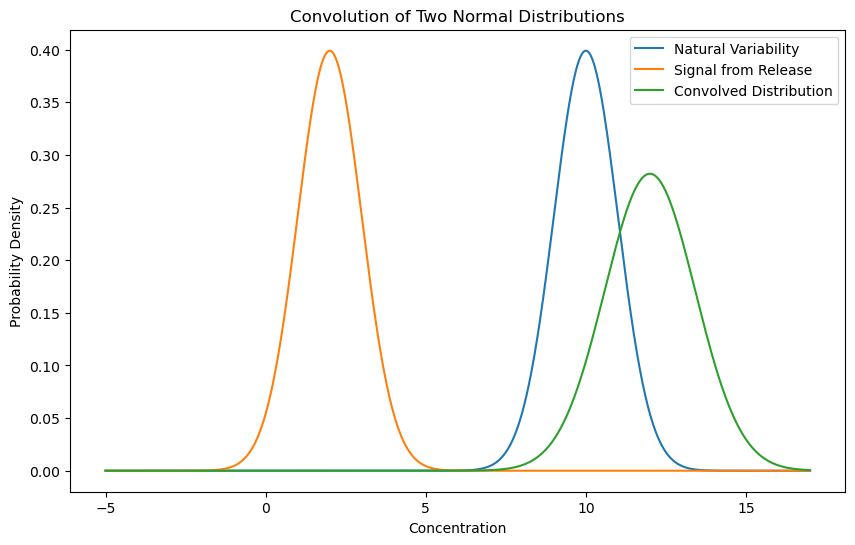

In [238]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the two normal distributions
mu1, sigma1 = 10, 1  # Natural variability
mu2, sigma2 = 2, 1  # Signal from release

# Create the distributions
x = np.linspace(-5, 17, 1000)
dist1 = norm.pdf(x, mu1, sigma1)
dist2 = norm.pdf(x, mu2, sigma2)

# Convolution of the two distributions
mu_conv = mu1 + mu2
sigma_conv = np.sqrt(sigma1**2 + sigma2**2)
dist_conv = norm.pdf(x, mu_conv, sigma_conv)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.plot(x, dist1, label='Natural Variability')
plt.plot(x, dist2, label='Signal from Release')
plt.plot(x, dist_conv, label='Convolved Distribution')
plt.legend()
plt.title('Convolution of Two Normal Distributions')
plt.xlabel('Concentration')
plt.ylabel('Probability Density')
plt.show()


## Bayes theorem and Monte Carlo
We’ll use Bayes’ theorem to update our belief about the concentration at the leak location. We’ll draw a random time series from the leak distribution and determine how many draws we need using Monte Carlo simulation.


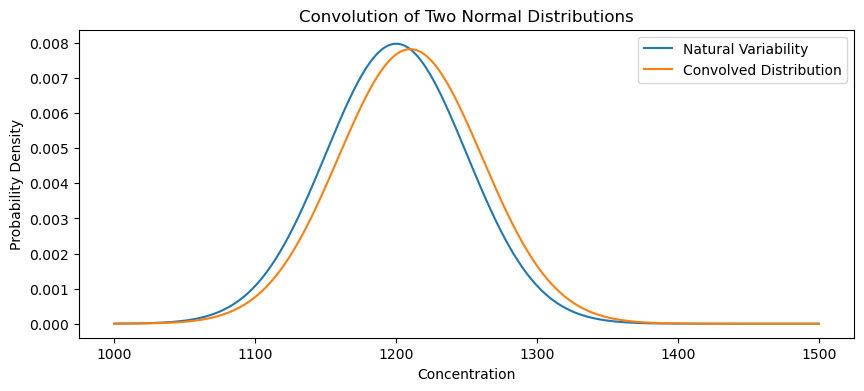

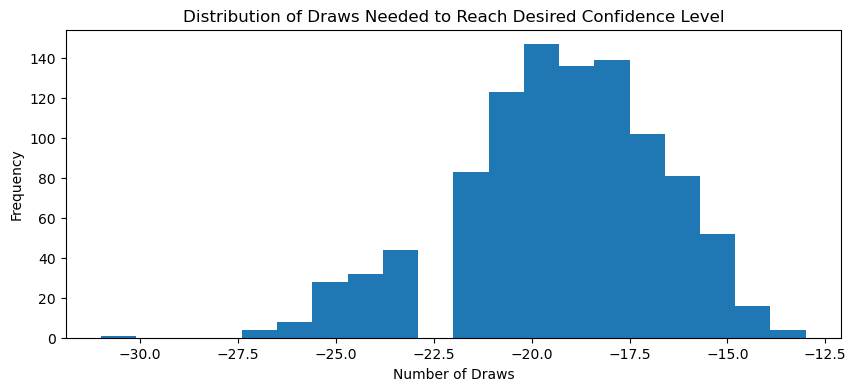

Average number of draws needed: -19.35


In [332]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the two normal distributions
mu1, sigma1 = 1200, 50  # Natural variability
mu2, sigma2 = 10, 10 # Signal from release

# Create the distributions
x = np.linspace(1000, 1500, 1000)
dist1 = norm.pdf(x, mu1, sigma1)
dist2 = norm.pdf(x, mu2, sigma2)

# Convolution of the two distributions
mu_conv = mu1 + mu2
sigma_conv = np.sqrt(sigma1**2 + sigma2**2)

dist_conv = norm.pdf(x, mu_conv, sigma_conv)

# Plot the distributions
plt.figure(figsize=(10, 4))
plt.plot(x, dist1, label='Natural Variability')
#plt.plot(x, dist2, label='Signal from Release')
plt.plot(x, dist_conv, label='Convolved Distribution')
plt.legend()
plt.title('Convolution of Two Normal Distributions')
plt.xlabel('Concentration')
plt.ylabel('Probability Density')
plt.show()
# Monte Carlo simulation to demonstrate Bayes theorem
#np.random.seed(42)  # For reproducibility

# Generate random samples from the leak location distribution
# Define the distributions
dist_no_leak = stats.norm(loc=mu1, scale=sigma1)  # Normal distribution with mean 0 and std 1
dist_leak = stats.norm(loc=mu_conv, scale=sigma_conv)  # Normal distribution with mean 1 and std 2
samples = dist_leak.rvs(1000)

# Prior probabilities (initial belief)
P_Leak = 0.5
P_No_Leak = 0.5

# Likelihood functions

# Function to update belief using Bayes theorem
def update_belief(P_Leak, P_No_Leak, likelihood_leak, likelihood_no_leak):
    P_Leak_given_data = likelihood_leak * P_Leak / (likelihood_leak * P_Leak + likelihood_no_leak * P_No_Leak)
    P_No_Leak_given_data = likelihood_no_leak * P_No_Leak / (likelihood_leak * P_Leak + likelihood_no_leak * P_No_Leak)
    return P_Leak_given_data, P_No_Leak_given_data

# Outer loop to get statistics on how many measurements we need
num_trials = 1000
threshold = 0.95  # Desired confidence level
draws_needed = []

for _ in range(num_trials):
    P_Leak = 0.5
    P_No_Leak = 0.5
    samples = dist_leak.rvs(1000)
    likelihood_leak = dist_leak.cdf(samples)
    likelihood_no_leak = dist_no_leak.cdf(samples)
    for i in range(len(samples)):
        P_Leak, P_No_Leak = update_belief(P_Leak, P_No_Leak, likelihood_leak[i], likelihood_no_leak[i])
        if P_Leak > threshold: 
            draws_needed.append(i + 1)
            break
        elif P_No_Leak > threshold:
            draws_needed.append(-(i + 1))
            break

# Plot the distribution of draws needed
plt.figure(figsize=(10, 4))
plt.hist(draws_needed, bins=20)
plt.title('Distribution of Draws Needed to Reach Desired Confidence Level')
plt.xlabel('Number of Draws')
plt.ylabel('Frequency')
plt.show()

print(f"Average number of draws needed: {np.mean(draws_needed):.2f}")


In [312]:
help(norm)

Help on norm_gen in module scipy.stats._continuous_distns:

<scipy.stats._continuous_distns.norm_gen object>
    A normal continuous random variable.
    
    The location (``loc``) keyword specifies the mean.
    The scale (``scale``) keyword specifies the standard deviation.
    
    As an instance of the `rv_continuous` class, `norm` object inherits from it
    a collection of generic methods (see below for the full list),
    and completes them with details specific for this particular distribution.
    
    Methods
    -------
    rvs(loc=0, scale=1, size=1, random_state=None)
        Random variates.
    pdf(x, loc=0, scale=1)
        Probability density function.
    logpdf(x, loc=0, scale=1)
        Log of the probability density function.
    cdf(x, loc=0, scale=1)
        Cumulative distribution function.
    logcdf(x, loc=0, scale=1)
        Log of the cumulative distribution function.
    sf(x, loc=0, scale=1)
        Survival function  (also defined as ``1 - cdf``, but `sf

## Three cities network

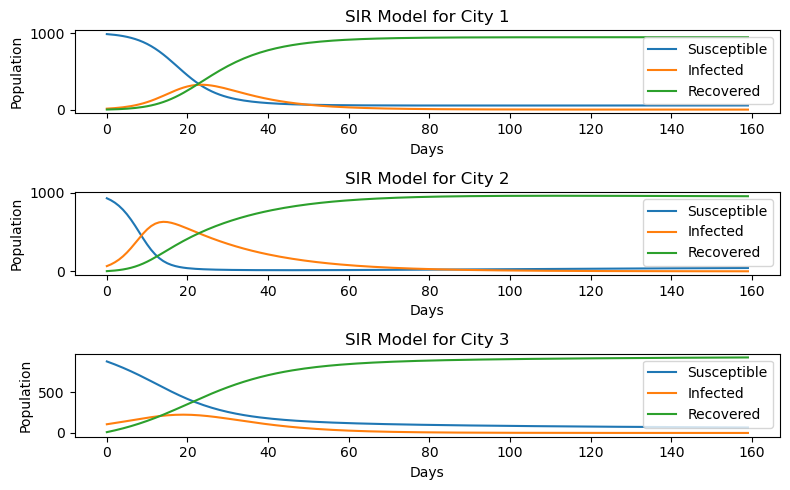

In [285]:
import numpy as np
import matplotlib.pyplot as plt

# Initial conditions for three cities
cities = [
    {"S": 990, "I": 10, "R": 0, "beta": 0.3, "gamma": 0.1, "N": 1000},
    {"S": 950, "I": 50, "R": 0, "beta": 0.4, "gamma": 0.05, "N": 1000},
    {"S": 900, "I": 100, "R": 0, "beta": 0.2, "gamma": 0.1, "N": 1000}
]

# Define the connectivity matrix
connectivity_matrix = np.array([
    [0, 0.5, 0.5],
    [0.5, 0, 0.5],
    [0.5, 0.5, 0]
])

# Define the SIR model with travel
def sir_model(S, I, R, beta, gamma, N, travel_rate, connectivity_matrix, city_index):
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    
    # Travel between cities
    for j in range(len(connectivity_matrix)):
        if j != city_index:
            dS += travel_rate * (cities[j]["S"] - S) * connectivity_matrix[city_index, j]
            dI += travel_rate * (cities[j]["I"] - I) * connectivity_matrix[city_index, j]
            dR += travel_rate * (cities[j]["R"] - R) * connectivity_matrix[city_index, j]
    
    return dS, dI, dR

# Simulation parameters
days = 160
dt = 1
travel_rate = 0.01  # Rate of travel between cities


# Initialize results storage
results = {i: {"S": [], "I": [], "R": []} for i in range(len(cities))}

# Run the simulation
for day in range(days):
    new_states = []
    for i, params in enumerate(cities):
        S, I, R = params["S"], params["I"], params["R"]
        beta, gamma, N = params["beta"], params["gamma"], params["N"]
        
        dS, dI, dR = sir_model(S, I, R, beta, gamma, N, travel_rate, connectivity_matrix, i)
        new_states.append({"S": S + dS * dt, "I": I + dI * dt, "R": R + dR * dt})
    
    for i, new_state in enumerate(new_states):
        cities[i]["S"], cities[i]["I"], cities[i]["R"] = new_state["S"], new_state["I"], new_state["R"]
        results[i]["S"].append(new_state["S"])
        results[i]["I"].append(new_state["I"])
        results[i]["R"].append(new_state["R"])

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(8, 5))

for i, data in results.items():
    axes[i].plot(data["S"], label="Susceptible")
    axes[i].plot(data["I"], label="Infected")
    axes[i].plot(data["R"], label="Recovered")
    axes[i].set_title(f"SIR Model for City {i+1}")
    axes[i].set_xlabel("Days")
    axes[i].set_ylabel("Population")
    axes[i].legend()

plt.tight_layout()
plt.show()
